In [1]:
from sudoku_smt_solvers.benchmarks.benchmark_runner import BenchmarkRunner

### Run experiments on 100 benchmarks

In [ ]:
runner = BenchmarkRunner(puzzles_dir='resources/benchmarks', results_dir='results', timeout=30)
runner.run_benchmarks()

### Load CSV Data for Results

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('results/results.csv')
print(df.head())

  solver                                          puzzle_id status  \
0   CVC5  sudoku_25x25_Extremely Easy_20241212_223411_pu...    sat   
1   CVC5           sudoku_25x25_Easy_20241212_223635_puzzle  unsat   
2   CVC5           sudoku_25x25_Easy_20241212_223654_puzzle  unsat   
3   CVC5      sudoku_25x25_Difficult_20241212_225638_puzzle  unsat   
4   CVC5      sudoku_25x25_Difficult_20241212_225229_puzzle    sat   

   solve_time  propagations  
0    0.856886          1158  
1    0.229691          1267  
2    0.237795          1246  
3    0.239885          1163  
4    0.671590          1166  


### Successfully Solved Puzzles

In [27]:
# Calculate metrics
results = df.groupby('solver').agg({
    'puzzle_id': ['count'],  # Total attempts
}).round(3)

# Rename columns and flatten
results.columns = ['total_puzzles']
results = results.reset_index()

# Add solved count (where status != timeout)
solved_counts = df[df['status'] != 'timeout'].groupby('solver').size()
results['solved_count'] = results['solver'].map(solved_counts)

# Calculate success rate
results['success_rate_%'] = (results['solved_count'] / results['total_puzzles'] * 100).round(1)

print("\nSolver Success Rates:")
print(results)


Solver Success Rates:
    solver  total_puzzles  solved_count  success_rate_%
0     CVC5            100           100           100.0
1     DPLL            100            97            97.0
2  DPLL(T)            100            97            97.0
3       Z3            100           100           100.0


### Average Time on Solved Instances

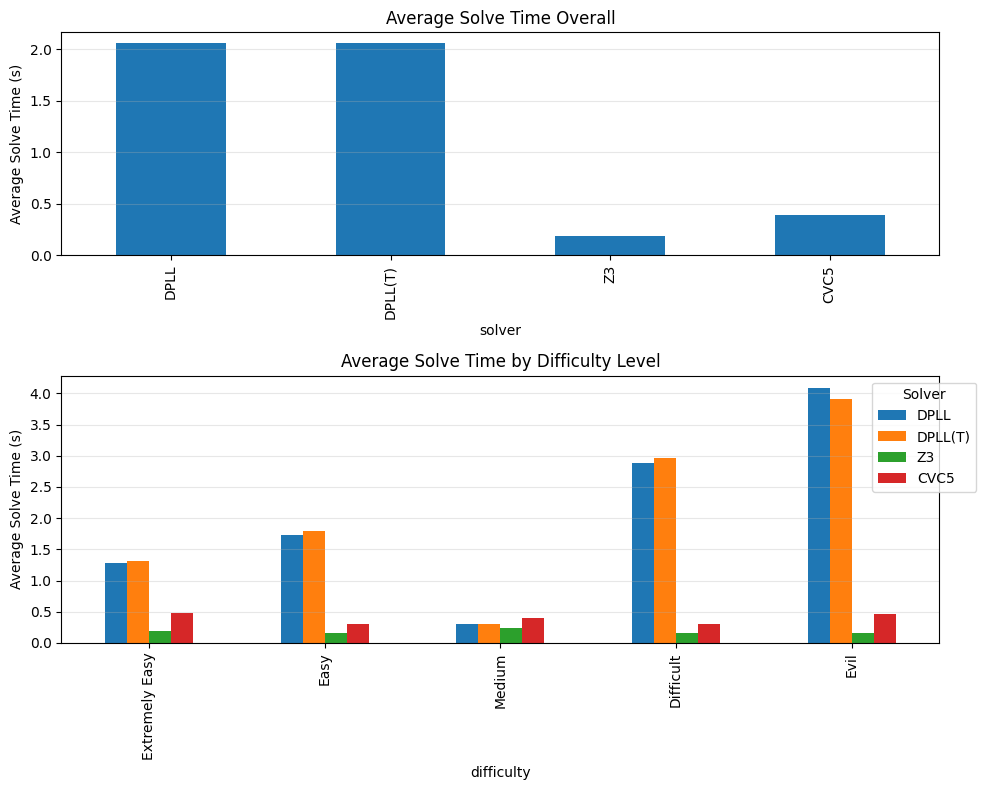

In [28]:
import matplotlib.pyplot as plt

# Define solver and difficulty orders
solver_order = ['DPLL', 'DPLL(T)', 'Z3', 'CVC5']
difficulty_order = ['Extremely Easy', 'Easy', 'Medium', 'Difficult', 'Evil']

# Process data
df['difficulty'] = df['puzzle_id'].str.extract(r'sudoku_\d+x\d+_(.+?)_\d+')
df['solve_time'] = df['solve_time'].astype(float)

# Define difficulty order
difficulty_order = ['Extremely Easy', 'Easy', 'Medium', 'Difficult', 'Evil']

# Create figure with vertical subplot arrangement
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top plot: Overall times (with ordered solvers)
overall_times = df.groupby('solver')['solve_time'].mean()[solver_order]
yerr = df.groupby('solver')['solve_time'].std()[solver_order]
overall_times.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Average Solve Time (s)')
ax1.set_title('Average Solve Time Overall')
ax1.grid(True, alpha=0.3, axis='y')

# Bottom plot: By difficulty (ordered by both dimensions)
difficulty_means = df.pivot_table(
    values='solve_time',
    index='difficulty',
    columns='solver',
    aggfunc='mean'
).reindex(difficulty_order)[solver_order]
difficulty_means.plot(kind='bar', ax=ax2)
ax2.set_ylabel('Average Solve Time (s)')
ax2.set_title('Average Solve Time by Difficulty Level')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(title='Solver', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

### Configuration Scatter on Runtime

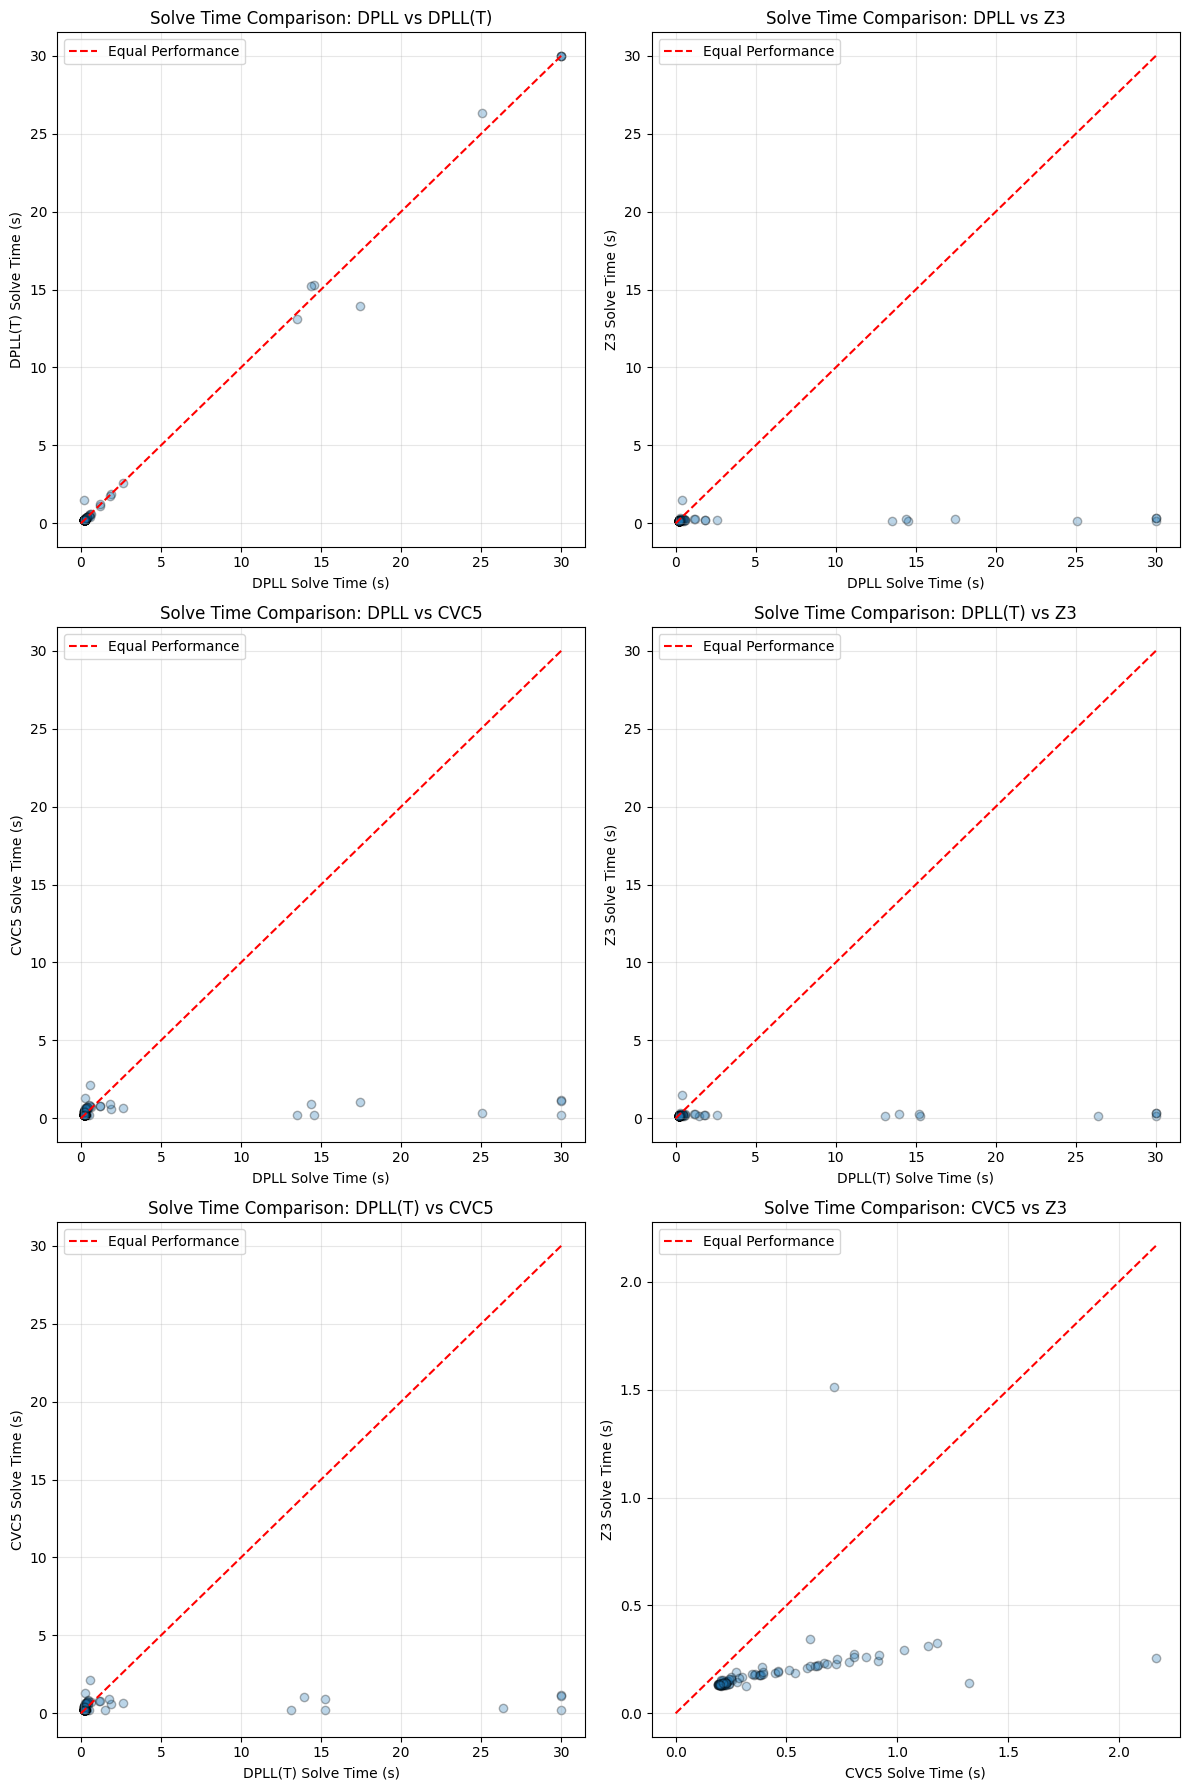

In [29]:
# Create a pivot table
pivot_data = df.pivot(index='puzzle_id', columns='solver', values='solve_time')

# Define solver pairs for comparisons
solver_pairs = [
    ('DPLL', 'DPLL(T)'),
    ('DPLL', 'Z3'),
    ('DPLL', 'CVC5'),
    ('DPLL(T)', 'Z3'),
    ('DPLL(T)', 'CVC5'),
    ('CVC5', 'Z3'),
]

# Create a 3x2 grid for scatter plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

# Generate scatter plots for each pair
for i, (solver_x, solver_y) in enumerate(solver_pairs):
    scatter_data = pivot_data[[solver_x, solver_y]].dropna()

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.scatter(scatter_data[solver_x], scatter_data[solver_y], alpha=0.3, edgecolor='k')

    # Add the equal performance line
    max_time = max(scatter_data[solver_x].max(), scatter_data[solver_y].max())
    ax.plot([0, max_time], [0, max_time], color='red', linestyle='--', label='Equal Performance')

    # Annotate the plot
    ax.set_title(f'Solve Time Comparison: {solver_x} vs {solver_y}')
    ax.set_xlabel(f'{solver_x} Solve Time (s)')
    ax.set_ylabel(f'{solver_y} Solve Time (s)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

### Average Propagated Clauses on Solved Instances

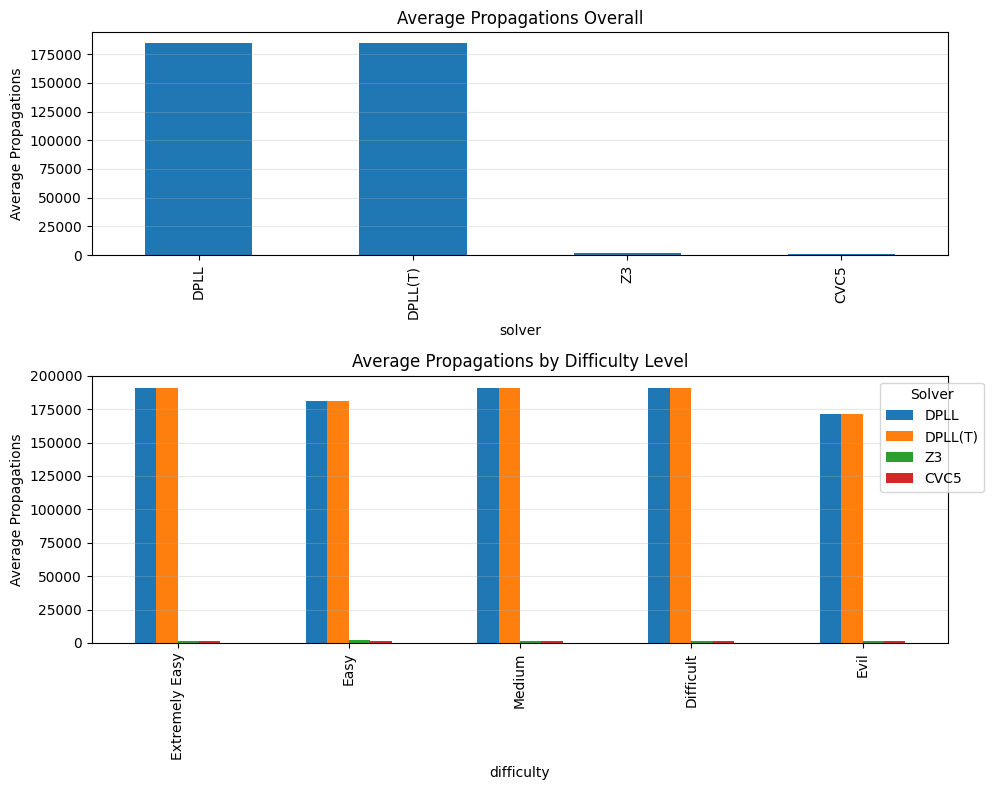

In [30]:
# Define solver and difficulty orders
solver_order = ['DPLL', 'DPLL(T)', 'Z3', 'CVC5']
difficulty_order = ['Extremely Easy', 'Easy', 'Medium', 'Difficult', 'Evil']

# Create figure with vertical subplot arrangement
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top plot: Overall times
overall_times = df.groupby('solver')['propagations'].mean().reindex(solver_order)
yerr = df.groupby('solver')['propagations'].std()
overall_times.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Average Propagations')
ax1.set_title('Average Propagations Overall')
ax1.grid(True, alpha=0.3, axis='y')

# Bottom plot: By difficulty (ordered)
difficulty_means = df.pivot_table(
    values='propagations',
    index='difficulty',
    columns='solver',
    aggfunc='mean'
).reindex(difficulty_order)[solver_order]
difficulty_means.plot(kind='bar', ax=ax2)
ax2.set_ylabel('Average Propagations')
ax2.set_title('Average Propagations by Difficulty Level')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(title='Solver', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()